# **Deep Neural Networks for Sentiment Analysis**
## In this notebook, we will focus on deploying and training deep neural networks for sentiment analysis for the Baldur's Gate 3 Steam Reviews dataset. Key steps include:
- Preprocessing the Data.
- Building Neural Network Architectures:
    - Simple RNN (Recurrent Neural Network)
    - LSTM (Long Short-Term Memory)
    - CNN (Convolutional Neural Network)
- Training the Models: Training the deep learning models on the dataset.
- Evaluating Performance: Measuring the models' accuracy and comparing their performance to traditional machine learning models.
*For this task, the detailed guidline from GeeksForGeeks website was followed: [guide](https://www.geeksforgeeks.org/sentiment-analysis-with-an-recurrent-neural-networks-rnn/)*

## Libraries for Data Analysis and Visualization
`%matplotlib inline` ensures that plots are displayed within the notebook.

In [44]:
# libraries for data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from time import perf_counter
import warnings
warnings.filterwarnings('ignore')

## TensorFlow and Keras for Deep Learning
The necessary components from TensorFlow and Keras are imported for building and training deep learning models.

In [45]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding, Dropout, Flatten, Conv1D, MaxPooling1D # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

## Scikit-learn Libraries
The following components from Scikit-learn are imported for data splitting and model evaluation.

In [46]:
# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

## Loading the Preprocessed Dataset
The preprocessed dataset is loaded from the `BG3_Cleaned.csv` file using Pandas and displayed the first 5 rows using `df.head()` function.

In [47]:
df = pd.read_csv('BG3_Cleaned.csv')
df.head()

,review,voted_up,without_stopwords,lemmatized
0,"['i', 'do', 'not', 'like', 'crpgs', 'or', 'fan...",1,"['not', 'like', 'crpgs', 'fantasy', 'setting',...","['not', 'like', 'crpgs', 'fantasy', 'setting',..."
1,"['is', 'good']",1,['good'],['good']
2,"['brief', 'background', 'dos', 'is', 'one', 'o...",0,"['brief', 'background', 'dos', 'one', 'favorit...","['brief', 'background', 'do', 'one', 'favorite..."
3,['ok'],1,['ok'],['ok']
4,"['i', 'genuinely', 'dont', 'understand', 'the'...",0,"['genuinely', 'dont', 'understand', 'hype', 'g...","['genuinely', 'dont', 'understand', 'hype', 'g..."


## Exploratory Data Analysis (EDA)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20314 entries, 0 to 20313
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review             20314 non-null  object
 1   voted_up           20314 non-null  int64 
 2   without_stopwords  20314 non-null  object
 3   lemmatized         20314 non-null  object
dtypes: int64(1), object(3)
memory usage: 634.9+ KB


In [49]:
df.describe()

,voted_up
count,20314.000000
mean,0.500000
std,0.500012
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [50]:
df['voted_up'].value_counts()

voted_up
1    10157
0    10157
Name: count, dtype: int64

## Analyzing Review Lengths
The minimum and maximum lengths of reviews are calculated for:
- Original Reviews
- Reviews Without Stopwords
- Lemmatized Reviews

In [51]:
# Min and Max length of origina reviews
print('Min length of reviews:', df['review'].apply(len).min())
print('Max length of reviews:', df['review'].apply(len).max())

# Min and Max length of reviews without stopwords
print('\nMin length of reviews without stopwords:', df['without_stopwords'].apply(len).min())
print('Max length of reviews without stopwords:', df['without_stopwords'].apply(len).max())

# Min and Max length of reviews lemmatized
print('\nMin length of reviews lemmatized:', df['lemmatized'].apply(len).min())
print('Max length of reviews lemmatized:', df['lemmatized'].apply(len).max())

Min length of reviews: 2
Max length of reviews: 12222

Min length of reviews without stopwords: 2
Max length of reviews without stopwords: 7778

Min length of reviews lemmatized: 2
Max length of reviews lemmatized: 7732


## Splitting the Data into Training, Validation, and Testing Sets
### Utilizing `train_test_split` function to split the data into training and testing sets for the original reviews, reviews without stopwords and lemmatized reviews
- **ws**: Without stop words
- **lem**: With lemmatization

The shapes of the resulting sets are printed to ensure the splits are correct.

In [52]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['voted_up'], test_size=0.2, random_state=42)
X_train_ws, X_test_ws, y_train_ws, y_test_ws = train_test_split(df['without_stopwords'], df['voted_up'], test_size=0.2, random_state=42)
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(df['lemmatized'], df['voted_up'], test_size=0.2, random_state=42)

# creating the valisation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train_ws, X_val_ws, y_train_ws, y_val_ws = train_test_split(X_train_ws, y_train_ws, test_size=0.1, random_state=42)
X_train_lem, X_val_lem, y_train_lem, y_val_lem = train_test_split(X_train_lem, y_train_lem, test_size=0.1, random_state=42)

# printing the shapes of the training and testing sets
print(f"Training set shape:     {X_train.shape}, {y_train.shape}")
print(f"Validation set shape:   {X_val.shape}, {y_val.shape}")
print(f"Testing set shape:      {X_test.shape}, {y_test.shape}")

Training set shape:     (14625,), (14625,)
Validation set shape:   (1626,), (1626,)
Testing set shape:      (4063,), (4063,)


`CountVectorizer` produces a large sparse matrix representing word frequencies. This works well for machine learning models but is less ideal for RNNs due to the lack of sequential structure.

Insetad, we will tokenize the text data and pad it into sequences of integers.

### Tokenizing Text Data
The `Tokenizer` is used to preprocess the text for deep learning models:
- **Vocabulary Size**: The total number of unique tokens in the dataset is calculated and printed.
- The text data is converted into sequences of integers where each integer represents a word.
- Sequences are generated for training, validation, and test sets.

In [53]:
# Initializing Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Get vocabulary size
vocab_size = len(tokenizer.word_index)  # Number of unique tokens
print("Vocabulary size:", vocab_size)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Vocabulary size: 28369


### Distribution of Review Lengths
- A histogram is plotted to visualize the distribution of review lengths in the training set.
- This visualization helps in determining a suitable maximum sequence length for padding

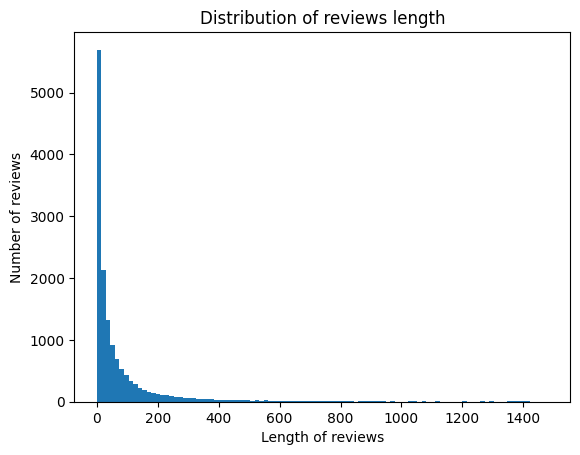

In [54]:
# Showing the distribution of the reviews length
plt.hist([len(review) for review in X_train_seq], bins=100)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Distribution of reviews length')
plt.show()

### Padding Sequences
Based on the review length distribution, a maximum sequence length of **400** is chosen to standardize input dimensions. `pad_sequences()` is used to apply this transformation to the training, validation, and test sets, all with the same length which is required for deep learning models.

In [ ]:
# Looking at the distribution of the reviews length, we choose a max length of 400
max_sequence_length = 400 
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

### The same process will be applied for reviews **without stopwords** and **lemmatized**.

In [56]:
# Initializing Tokenizer for data without stopwords
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(X_train_ws)

# Get vocabulary size
vocab_size2 = len(tokenizer2.word_index)  # Number of unique tokens
print("Vocabulary size:", vocab_size2)

# Convert text to sequences
X_train_ws_seq = tokenizer.texts_to_sequences(X_train_ws)
X_val_ws_seq = tokenizer.texts_to_sequences(X_val_ws)
X_test_ws_seq = tokenizer.texts_to_sequences(X_test_ws)

Vocabulary size: 28234


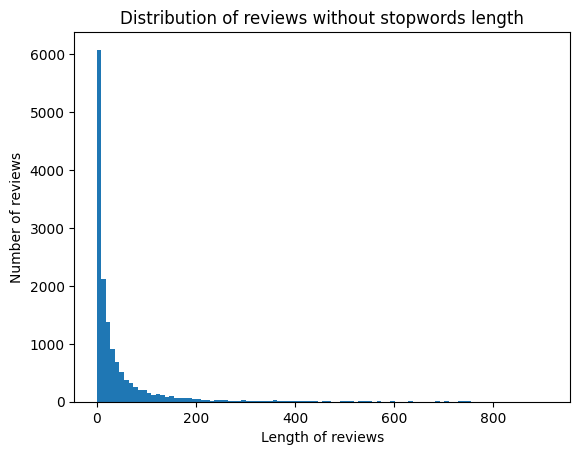

In [57]:
# Showing the distribution of the reviews length
plt.hist([len(review) for review in X_train_ws_seq], bins=100)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Distribution of reviews without stopwords length')
plt.show()

In [58]:
# Looking at the distribution of the reviews without stopwords length, we choose a max length of 200
max_sequence_length2 = 200 
X_train_ws_padded = pad_sequences(X_train_ws_seq, maxlen=max_sequence_length2)
X_val_ws_padded = pad_sequences(X_val_ws_seq, maxlen=max_sequence_length2)
X_test_ws_padded = pad_sequences(X_test_ws_seq, maxlen=max_sequence_length2)

In [59]:
# Initializing Tokenizer for lemmatized data
tokenizer3 = Tokenizer()
tokenizer3.fit_on_texts(X_train_lem)

# Get vocabulary size
vocab_size3 = len(tokenizer3.word_index)  # Number of unique tokens
print("Vocabulary size:", vocab_size3)

# Convert text to sequences
X_train_lem_seq = tokenizer.texts_to_sequences(X_train_lem)
X_val_lem_seq = tokenizer.texts_to_sequences(X_val_lem)
X_test_lem_seq = tokenizer.texts_to_sequences(X_test_lem)

Vocabulary size: 25778


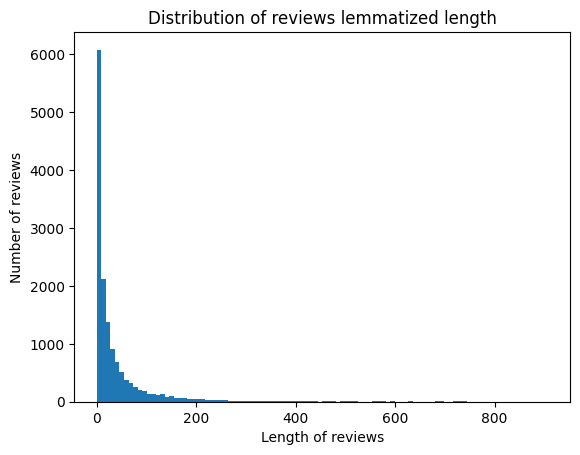

In [60]:
# Showing the distribution of the reviews length
plt.hist([len(review) for review in X_train_lem_seq], bins=100)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Distribution of reviews lemmatized length')
plt.show()

In [61]:
# Looking at the distribution of the reviews lemmatized length, we choose a max length of 200
max_sequence_length3 = 200
X_train_lem_padded = pad_sequences(X_train_lem_seq, maxlen=max_sequence_length3)
X_val_lem_padded = pad_sequences(X_val_lem_seq, maxlen=max_sequence_length3)
X_test_lem_padded = pad_sequences(X_test_lem_seq, maxlen=max_sequence_length3)

## **Building and Training a Simple RNN Model**
A simple Recurrent Neural Network (RNN) is created and trained for sentiment analysis.

### **Original Reviews**

In [62]:
# fixing every word's embedding size to be 32
embd_len = 32

# Creating a RNN model
RNN_model = Sequential(name="Simple_RNN")
RNN_model.add(Embedding(input_dim = vocab_size, output_dim = embd_len, input_length=max_sequence_length))
RNN_model.add(SimpleRNN(128, activation='tanh', return_sequences=False))
RNN_model.add(Dense(1, activation='sigmoid'))

# Compiling model
# Using GPU for training
with tf.device('/GPU:0'):
    RNN_model.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
# Training the model
start1 = perf_counter()
history = RNN_model.fit(X_train_padded, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(X_val_padded, y_val))
end1 = perf_counter()
RNN_model.summary()
# Printing model score on test data
print("\nSimple_RNN Score---> ", RNN_model.evaluate(X_test_padded, y_test, verbose=0))
# Total time taken for training the model
print(f"Time taken to train model: {end1-start1}")
# Number of parameters in the model
print("Total number of parameters: ", RNN_model.count_params())

Epoch 1/5


I0000 00:00:1734880596.555860    9382 service.cc:148] XLA service 0x7f79ec093a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734880596.556579    9382 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-12-22 17:16:36.612694: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734880598.917849    9382 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


229/229 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5498 - loss: 0.6859 - val_accuracy: 0.7811 - val_loss: 0.4675
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7724 - loss: 0.4718 - val_accuracy: 0.8530 - val_loss: 0.3585
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8662 - loss: 0.3212 - val_accuracy: 0.8247 - val_loss: 0.4128
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9042 - loss: 0.2392 - val_accuracy: 0.8641 - val_loss: 0.3743
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9300 - loss: 0.1877 - val_accuracy: 0.8506 - val_loss: 0.3773


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 400, 32)        │       907,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,785,637 (10.63 MB)

 Trainable params: 928,545 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,857,092 (7.08 MB)


Simple_RNN Score--->  [0.4044964015483856, 0.8402658104896545]
Time taken to train model: 35.75413692999973
Total number of parameters:  928545


### **Reviews without Stopwords**

In [63]:
# Creating a RNN model without stopwords
RNN_model_ws = Sequential(name="Simple_RNN_Without_Stopwords")
RNN_model_ws.add(Embedding(input_dim = vocab_size2, output_dim = embd_len, input_length=max_sequence_length2))
RNN_model_ws.add(SimpleRNN(128, activation='tanh', return_sequences=False))
RNN_model_ws.add(Dense(1, activation='sigmoid'))

# Compiling model
# Using GPU for training
with tf.device('/GPU:0'):
    RNN_model_ws.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
# Training the model
start2 = perf_counter()
history2 = RNN_model_ws.fit(X_train_ws_padded, y_train_ws, batch_size=64, epochs=5, verbose=1, validation_data=(X_val_ws_padded, y_val_ws))
end2 = perf_counter()
RNN_model_ws.summary()
# Printing model score on test data
print("\nSimple_RNN Score---> ", RNN_model_ws.evaluate(X_test_ws_padded, y_test_ws, verbose=0))
# Total time taken for training the model
print(f"Time taken to train model: {end2-start2}")
# Number of parameters in the model
print("Total number of parameters: ", RNN_model_ws.count_params())

Epoch 1/5


229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6515 - loss: 0.6111 - val_accuracy: 0.8653 - val_loss: 0.3487
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8751 - loss: 0.3024 - val_accuracy: 0.8856 - val_loss: 0.2864
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9324 - loss: 0.1845 - val_accuracy: 0.8186 - val_loss: 0.4005
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8739 - loss: 0.3262 - val_accuracy: 0.8819 - val_loss: 0.3118
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9205 - loss: 0.2067 - val_accuracy: 0.7657 - val_loss: 0.4977


Model: "Simple_RNN_Without_Stopwords"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 200, 32)        │       903,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,772,677 (10.58 MB)

 Trainable params: 924,225 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,848,452 (7.05 MB)


Simple_RNN Score--->  [0.5039650797843933, 0.7698744535446167]
Time taken to train model: 18.651229499000692
Total number of parameters:  924225


### **Lemmatized Reviews**

In [64]:
# Creating a RNN model with lemmatized data
RNN_model_lem = Sequential(name="Simple_RNN_Lemmatized")
RNN_model_lem.add(Embedding(input_dim = vocab_size3, output_dim = embd_len, input_length=max_sequence_length3))
RNN_model_lem.add(SimpleRNN(128, activation='tanh', return_sequences=False))
RNN_model_lem.add(Dense(1, activation='sigmoid'))

# Compiling model
# Using GPU for training
with tf.device('/GPU:0'):
    RNN_model_lem.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
# Training the model
start3 = perf_counter()
history3 = RNN_model_lem.fit(X_train_lem_padded, y_train_lem, batch_size=64, epochs=5, verbose=1, validation_data=(X_val_lem_padded, y_val_lem))
end3 = perf_counter()
RNN_model_lem.summary()
# Printing model score on test data
print("\nSimple_RNN Score---> ", RNN_model_lem.evaluate(X_test_lem_padded, y_test_lem, verbose=0))
# Total time taken for training the model
print(f"Time taken to train model: {end3-start3}")
# Number of parameters in the model
print("Total number of parameters: ", RNN_model_lem.count_params())

Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7181 - loss: 0.5620 - val_accuracy: 0.8875 - val_loss: 0.3119
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8889 - loss: 0.2782 - val_accuracy: 0.8936 - val_loss: 0.2724
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9295 - loss: 0.1945 - val_accuracy: 0.8911 - val_loss: 0.2969
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9485 - loss: 0.1490 - val_accuracy: 0.8850 - val_loss: 0.3272
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9593 - loss: 0.1178 - val_accuracy: 0.8733 - val_loss: 0.3937


Model: "Simple_RNN_Lemmatized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 200, 32)        │       824,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,536,901 (9.68 MB)

 Trainable params: 845,633 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,691,268 (6.45 MB)


Simple_RNN Score--->  [0.4308280944824219, 0.8562638163566589]
Time taken to train model: 20.52291356599926
Total number of parameters:  845633


## **Building and Training an LSTM Model**
## Following this [guide](https://javilopezcastillo.medium.com/sentiment-analysis-using-lstm-networks-a-deep-dive-into-textual-data-61cdd2e43dec), we created the LSTM model with these specific characteristics.
- Dropout is a regularizing technique that randomly sets a fraction of the input units as zero to deal with overfitting.
- Two LSTM layers, the first outputs sequences (`return_sequences=True`).
- Another one (`Dense`) fully connected layer with 64 units and '`relu`' activation function to introduce non-linearity to the model.

This architecture leverages the strength of LSTM layers to capture sequential patterns in the text data for improved sentiment classification.

In [118]:
embd_len = 32
# Defining LSTM model with original data
lstm_model = Sequential(name="LSTM_Model")
lstm_model.add(Embedding(vocab_size, embd_len, input_length=max_sequence_length))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
lstm_model.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Training the model
start4 = perf_counter()
with tf.device('/GPU:0'):
    history4 = lstm_model.fit(X_train_padded, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_val_padded, y_val))
end4 = perf_counter()
lstm_model.summary()
# Displaying the model accuracy on test data
print("\nLSTM model Score---> ", lstm_model.evaluate(X_test_padded, y_test, verbose=0))

# Total time taken for training the model
print(f"Time taken to train model: {end4-start4}")
# Number of parameters in the model
print("Total number of parameters: ", lstm_model.count_params())

Epoch 1/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.7317 - loss: 0.5419 - val_accuracy: 0.8604 - val_loss: 0.3559
Epoch 2/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.8837 - loss: 0.3132 - val_accuracy: 0.8407 - val_loss: 0.3938
Epoch 3/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.8959 - loss: 0.2840 - val_accuracy: 0.8678 - val_loss: 0.3370
Epoch 4/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.9272 - loss: 0.2001 - val_accuracy: 0.8967 - val_loss: 0.2919
Epoch 5/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.9331 - loss: 0.1880 - val_accuracy: 0.8801 - val_loss: 0.3255


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 400, 32)        │       907,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 400, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 400, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,390,437 (12.93 MB)

 Trainable params: 1,130,145 (4.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,260,292 (8.62 MB)


LSTM model Score--->  [0.32287102937698364, 0.8828451633453369]
Time taken to train model: 147.37468085299952
Total number of parameters:  1130145


In [117]:
# Defining LSTM model with data without stopwords
lstm_model_ws = Sequential(name="LSTM_Model_Without_Stopwords")
lstm_model_ws.add(Embedding(vocab_size2, embd_len, input_length=max_sequence_length2))
lstm_model_ws.add(LSTM(128, return_sequences=True))
lstm_model_ws.add(Dropout(0.5))
lstm_model_ws.add(LSTM(128))
lstm_model_ws.add(Dense(64, activation='relu'))
lstm_model_ws.add(Dense(1, activation='sigmoid'))

# Compiling the model
lstm_model_ws.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Training the model
start5 = perf_counter()
with tf.device('/GPU:0'):
    history5 = lstm_model_ws.fit(X_train_ws_padded, y_train_ws, batch_size=32, epochs=5, verbose=1, validation_data=(X_val_ws_padded, y_val_ws))
end5 = perf_counter()
lstm_model_ws.summary()
# Displaying the model accuracy on test data
print("\nLSTM model Score---> ", lstm_model_ws.evaluate(X_test_ws_padded, y_test_ws, verbose=0))

# Total time taken for training the model
print(f"Time taken to train model: {end5-start5}")
# Number of parameters in the model
print("Total number of parameters: ", lstm_model_ws.count_params())

Epoch 1/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7532 - loss: 0.5008 - val_accuracy: 0.8868 - val_loss: 0.2985
Epoch 2/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9014 - loss: 0.2557 - val_accuracy: 0.8764 - val_loss: 0.2836
Epoch 3/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9463 - loss: 0.1485 - val_accuracy: 0.8819 - val_loss: 0.3306
Epoch 4/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9573 - loss: 0.1182 - val_accuracy: 0.8745 - val_loss: 0.3513
Epoch 5/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9669 - loss: 0.0909 - val_accuracy: 0.8733 - val_loss: 0.3859


Model: "LSTM_Model_Without_Stopwords"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 200, 32)        │       903,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 200, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,377,477 (12.88 MB)

 Trainable params: 1,125,825 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,251,652 (8.59 MB)


LSTM model Score--->  [0.4093576967716217, 0.8734924793243408]
Time taken to train model: 86.00177185299981
Total number of parameters:  1125825


In [120]:
# Defining LSTM model with lemmatized data
lstm_model_lem = Sequential(name="LSTM_Model_Lemmatized")
lstm_model_lem.add(Embedding(vocab_size3, embd_len, input_length=max_sequence_length3))
lstm_model_lem.add(LSTM(128, return_sequences=True))
lstm_model_lem.add(Dropout(0.5))
lstm_model_lem.add(LSTM(128))
lstm_model_lem.add(Dense(64, activation='relu'))
lstm_model_lem.add(Dense(1, activation='sigmoid'))

# Compiling the model
lstm_model_lem.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Training the model
start6 = perf_counter()
with tf.device('/GPU:0'):
    history6 = lstm_model_lem.fit(X_train_lem_padded, y_train_lem, batch_size=32, epochs=5, verbose=1, validation_data=(X_val_lem_padded, y_val_lem))
end6 = perf_counter()
lstm_model_lem.summary()
# Displaying the model accuracy on test data
print("\nLSTM model Score---> ", lstm_model_lem.evaluate(X_test_lem_padded, y_test_lem, verbose=0))

# Total time taken for training the model
print(f"Time taken to train model: {end6-start6}")
# Number of parameters in the model
print("Total number of parameters: ", lstm_model_lem.count_params())

Epoch 1/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.7542 - loss: 0.5042 - val_accuracy: 0.8875 - val_loss: 0.2888
Epoch 2/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9040 - loss: 0.2458 - val_accuracy: 0.8924 - val_loss: 0.3019
Epoch 3/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9408 - loss: 0.1658 - val_accuracy: 0.8807 - val_loss: 0.3149
Epoch 4/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9572 - loss: 0.1289 - val_accuracy: 0.8844 - val_loss: 0.3111
Epoch 5/5
458/458 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9655 - loss: 0.0989 - val_accuracy: 0.8868 - val_loss: 0.3865


Model: "LSTM_Model_Lemmatized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 200, 32)        │       824,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 200, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,141,701 (11.98 MB)

 Trainable params: 1,047,233 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,094,468 (7.99 MB)


LSTM model Score--->  [0.42798733711242676, 0.8737386465072632]
Time taken to train model: 97.3026399270002
Total number of parameters:  1047233


## **Building and Training a CNN Model**
A Convolutional Neural Network (CNN) is designed and trained for sentiment analysis, following this [guide](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/).

The CNN architecture effectively captures spatial patterns in text data for sentiment classification.

In [68]:
# Defining CNN model
cnn_model = Sequential(name="CNN_Model")
cnn_model.add(Embedding(vocab_size, embd_len, input_length=max_sequence_length))
cnn_model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
cnn_model.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Training the model
start7 = perf_counter()
with tf.device('/GPU:0'):
    history7 = cnn_model.fit(X_train_padded, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(X_val_padded, y_val))
end7 = perf_counter()
cnn_model.summary()

# Displaying the model accuracy on test data
print()
print("\nCNN model Score---> ", cnn_model.evaluate(X_test_padded, y_test, verbose=0))

# Total time taken for training the model
print(f"Time taken to train model: {end7-start7}")
# Number of parameters in the model
print("Total number of parameters: ", cnn_model.count_params())

Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7152 - loss: 0.5610 - val_accuracy: 0.8708 - val_loss: 0.3133
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8960 - loss: 0.2609 - val_accuracy: 0.8715 - val_loss: 0.3071
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9322 - loss: 0.1907 - val_accuracy: 0.8825 - val_loss: 0.3171
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9509 - loss: 0.1432 - val_accuracy: 0.8776 - val_loss: 0.3549
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9610 - loss: 0.1116 - val_accuracy: 0.8801 - val_loss: 0.4087


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 400, 32)        │       907,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 393, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 196, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │        62,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,936,321 (11.20 MB)

 Trainable params: 978,773 (3.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,957,548 (7.47 MB)



CNN model Score--->  [0.42276322841644287, 0.8776766061782837]
Time taken to train model: 5.009701556999062
Total number of parameters:  978773


In [69]:
# Defining CNN model with data without stopwords
cnn_model_ws = Sequential(name="CNN_Model_Without_Stopwords")
cnn_model_ws.add(Embedding(vocab_size2, embd_len, input_length=max_sequence_length2))
cnn_model_ws.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
cnn_model_ws.add(MaxPooling1D(pool_size=2))
cnn_model_ws.add(Flatten())
cnn_model_ws.add(Dense(10, activation='relu'))
cnn_model_ws.add(Dense(1, activation='sigmoid'))

# Compiling the model
cnn_model_ws.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Training the model
start8 = perf_counter()
with tf.device('/GPU:0'):
    history8 = cnn_model_ws.fit(X_train_ws_padded, y_train_ws, batch_size=64, epochs=5, verbose=1, validation_data=(X_val_ws_padded, y_val_ws))
end8 = perf_counter()
cnn_model_ws.summary()

# Displaying the model accuracy on test data
print("\nCNN model Score---> ", cnn_model_ws.evaluate(X_test_ws_padded, y_test_ws, verbose=0))

# Total time taken for training the model
print(f"Time taken to train model: {end8-start8}")
# Number of parameters in the model
print("Total number of parameters: ", cnn_model_ws.count_params())

Epoch 1/5


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7326 - loss: 0.5576 - val_accuracy: 0.8733 - val_loss: 0.3299
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8967 - loss: 0.2700 - val_accuracy: 0.8721 - val_loss: 0.3238
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9297 - loss: 0.1905 - val_accuracy: 0.8665 - val_loss: 0.3580
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9486 - loss: 0.1458 - val_accuracy: 0.8641 - val_loss: 0.4229
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9624 - loss: 0.1085 - val_accuracy: 0.8579 - val_loss: 0.4851


Model: "CNN_Model_Without_Stopwords"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 200, 32)        │       903,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 193, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 96, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │        30,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,827,361 (10.79 MB)

 Trainable params: 942,453 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,884,908 (7.19 MB)


CNN model Score--->  [0.47287747263908386, 0.8636475801467896]
Time taken to train model: 4.645215552998707
Total number of parameters:  942453


In [70]:
# Defining CNN model with lemmatized data
cnn_model_lem = Sequential(name="CNN_Model_Lemmatized")
cnn_model_lem.add(Embedding(vocab_size3, embd_len, input_length=max_sequence_length3))
cnn_model_lem.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
cnn_model_lem.add(MaxPooling1D(pool_size=2))
cnn_model_lem.add(Flatten())
cnn_model_lem.add(Dense(10, activation='relu'))
cnn_model_lem.add(Dense(1, activation='sigmoid'))

# Compiling the model
cnn_model_lem.compile( loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Training the model
start9 = perf_counter()
with tf.device('/GPU:0'):
    history9 = cnn_model_lem.fit(X_train_lem_padded, y_train_lem, batch_size=64, epochs=5, verbose=1, validation_data=(X_val_lem_padded, y_val_lem))
end9 = perf_counter()
cnn_model_lem.summary()

# Displaying the model accuracy on test data
print("\nCNN model Score---> ", cnn_model_lem.evaluate(X_test_lem_padded, y_test_lem, verbose=0))

# Total time taken for training the model
print(f"Time taken to train model: {end9-start9}")
# Number of parameters in the model
print("Total number of parameters: ", cnn_model_lem.count_params())

Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7056 - loss: 0.5598 - val_accuracy: 0.8727 - val_loss: 0.3157
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8941 - loss: 0.2757 - val_accuracy: 0.8770 - val_loss: 0.3047
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9301 - loss: 0.1935 - val_accuracy: 0.8752 - val_loss: 0.3254
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9474 - loss: 0.1501 - val_accuracy: 0.8672 - val_loss: 0.3956
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9575 - loss: 0.1231 - val_accuracy: 0.8665 - val_loss: 0.4600


Model: "CNN_Model_Lemmatized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 200, 32)        │       824,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 193, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 96, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │        30,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,585 (9.89 MB)

 Trainable params: 863,861 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,727,724 (6.59 MB)


CNN model Score--->  [0.4827396869659424, 0.8599556684494019]
Time taken to train model: 4.40187843700005
Total number of parameters:  863861


## Visualizing Model Training History

### The training and validation performance of the **Simple RNN** model is visualized for each review processing stage

#### Original Reviews

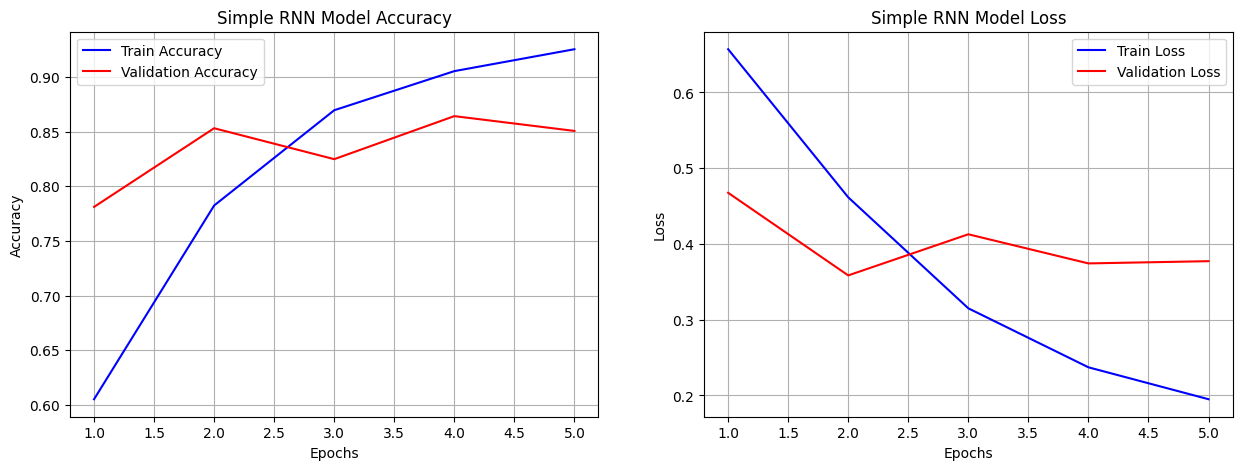

In [121]:
# History plot for accuracy and loss, for both training and validation, using seaborn for better visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('Simple RNN Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('Simple RNN Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

#### Reviews without Stopwords

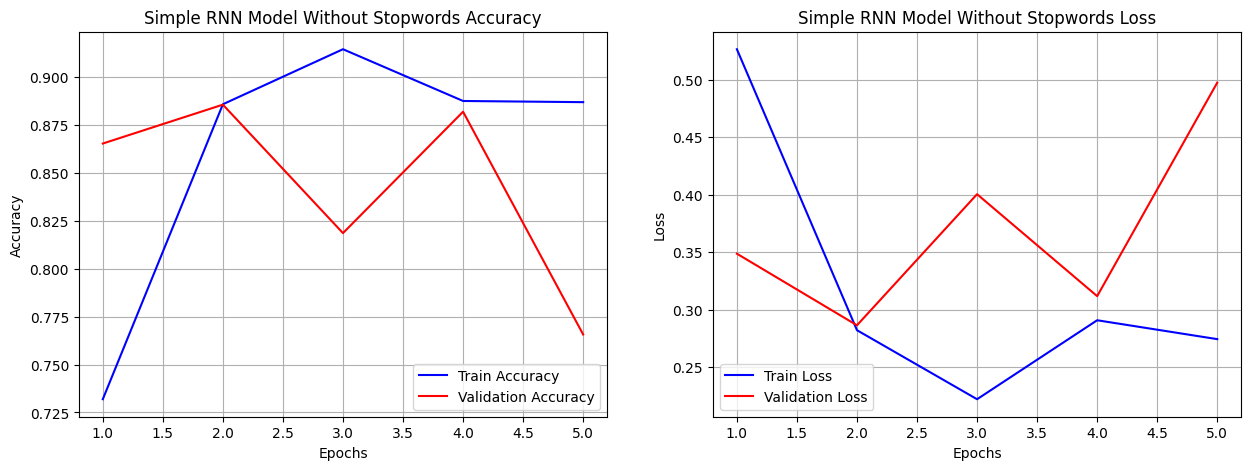

In [122]:
# Simple RNN model without stopwords
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history2.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history2.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('Simple RNN Model Without Stopwords Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history2.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history2.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('Simple RNN Model Without Stopwords Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

#### Lemmatized Reviews

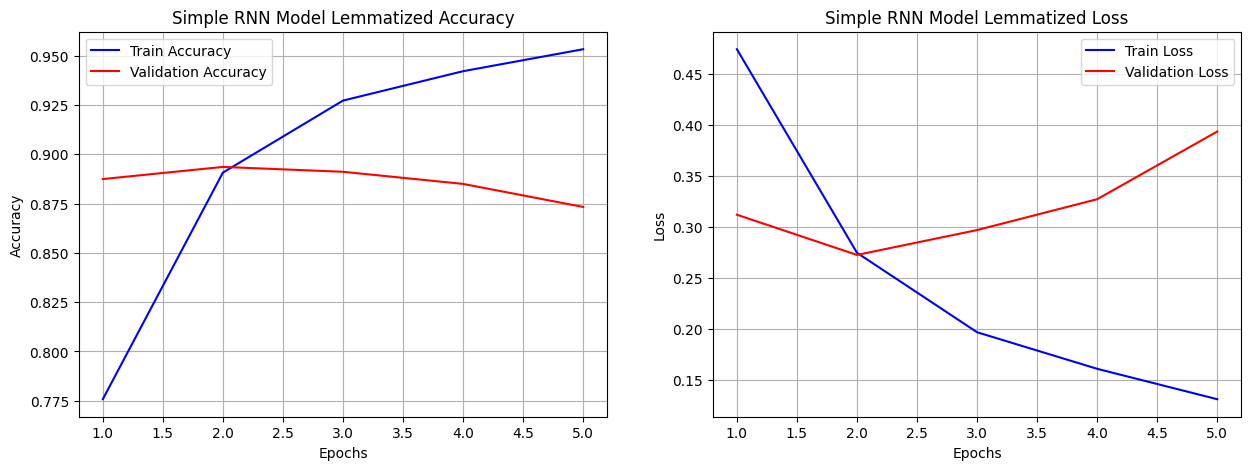

In [123]:
# SimpleRNN model with lemmatized data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history3.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history3.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('Simple RNN Model Lemmatized Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history3.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history3.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('Simple RNN Model Lemmatized Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

### The training and validation performance of the **LSTM** model is visualized

#### Original Reviews

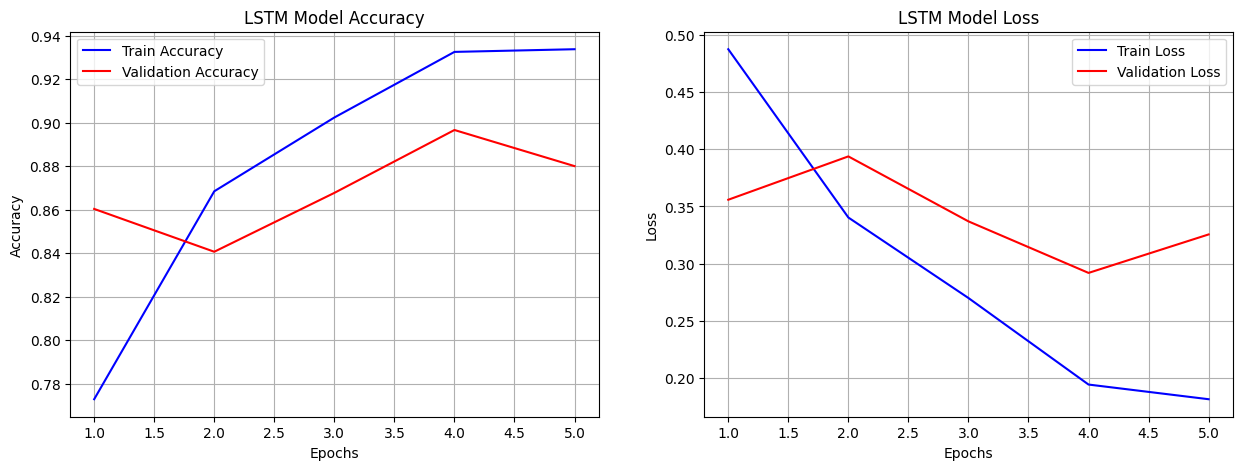

In [124]:
# LSTM model with original data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history4.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history4.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('LSTM Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history4.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history4.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('LSTM Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

#### Reviews without Stopwords

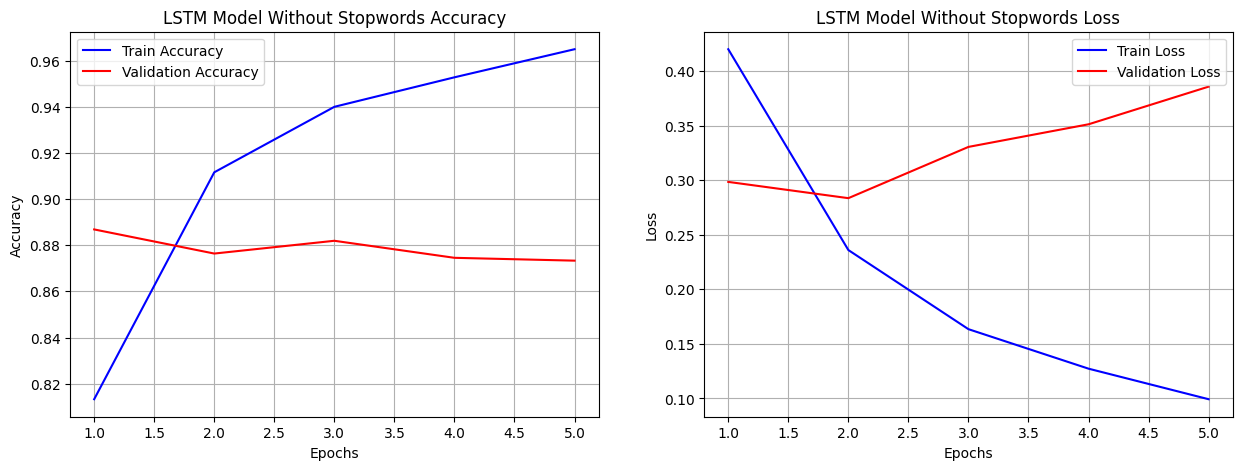

In [125]:
# LSTM model without stopwords
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history5.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history5.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('LSTM Model Without Stopwords Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history5.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history5.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('LSTM Model Without Stopwords Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

#### Lemmatized Reviews

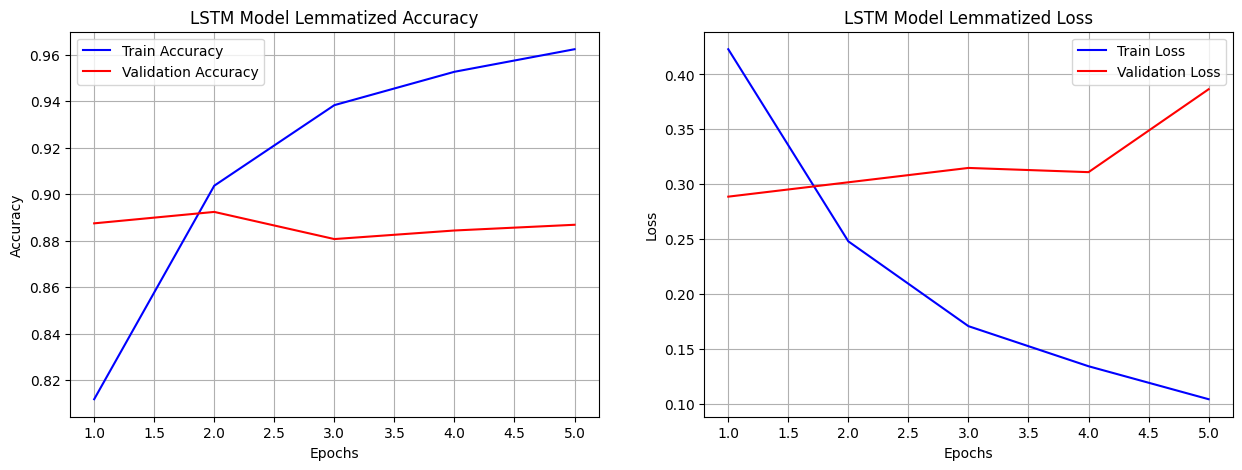

In [126]:
# LSTM model with lemmatized data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history6.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history6.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('LSTM Model Lemmatized Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history6.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history6.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('LSTM Model Lemmatized Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

### The training and validation performance of the **CNN** model is visualized

#### Original Reviews

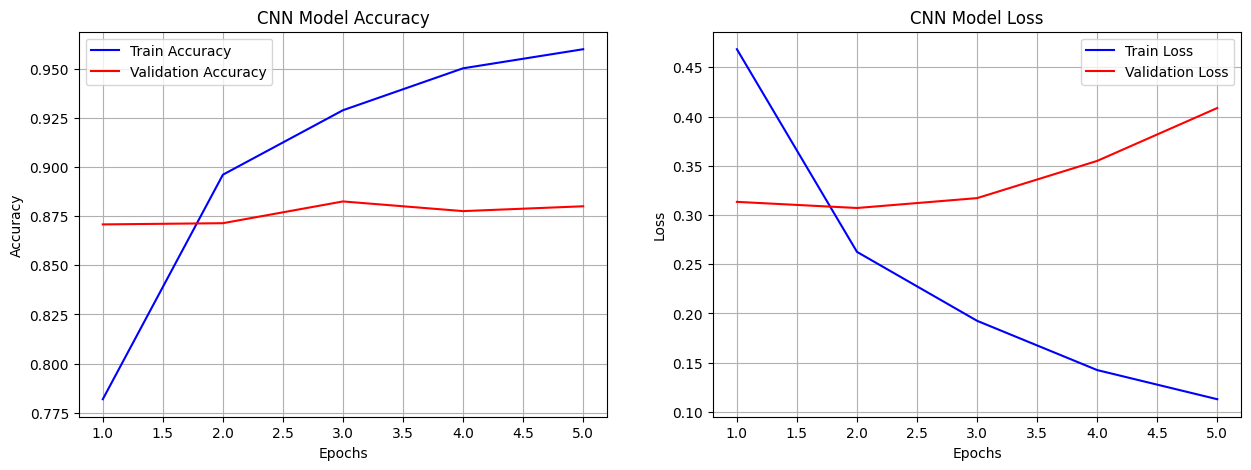

In [127]:
# CNN model with original data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history7.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history7.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('CNN Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history7.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history7.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('CNN Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

#### Reviews without Stopwords

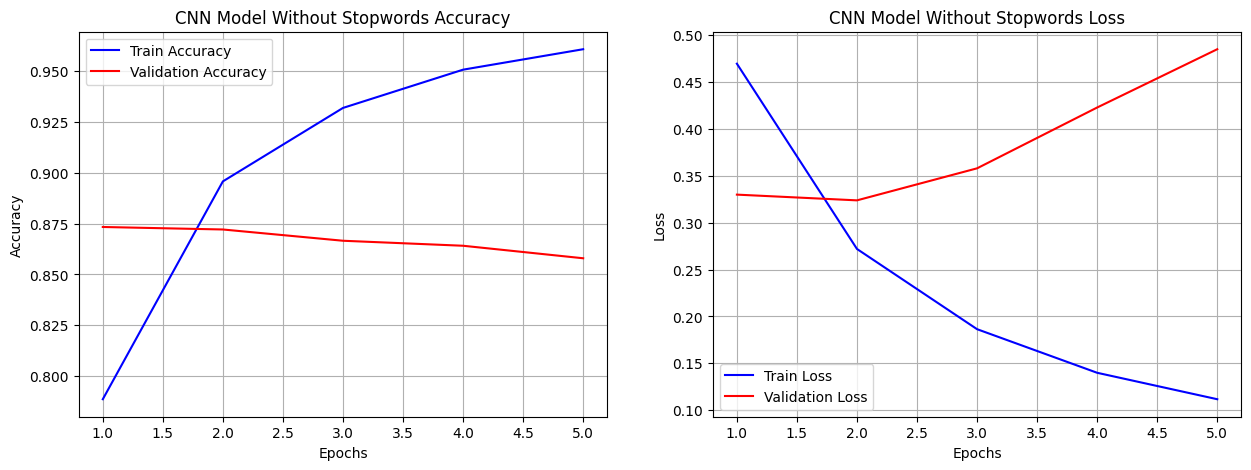

In [128]:
# CNN model without stopwords
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history8.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history8.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('CNN Model Without Stopwords Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history8.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history8.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('CNN Model Without Stopwords Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

#### Lemmatized Reviews

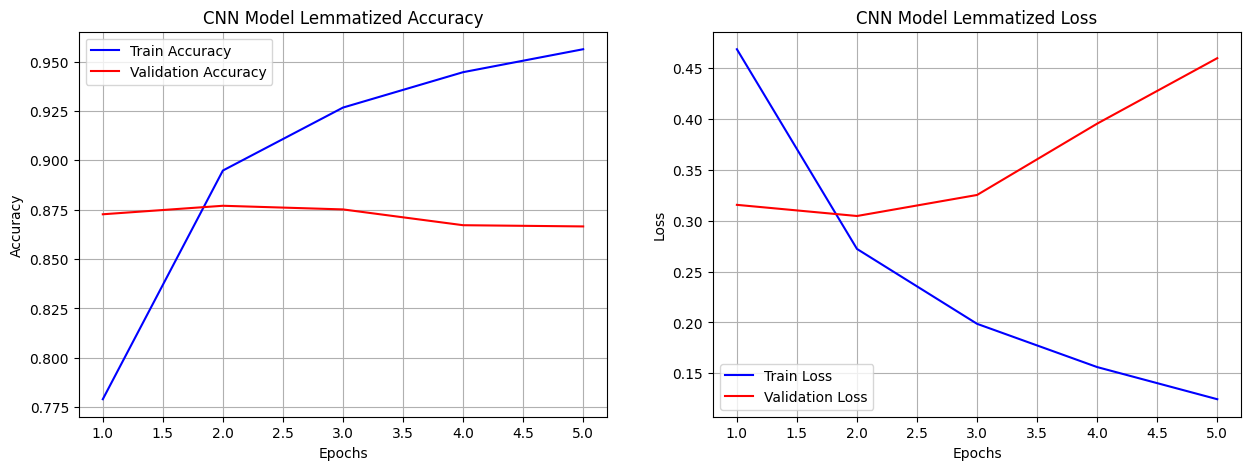

In [129]:
# CNN model with lemmatized data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Accuracy plot
sns.lineplot(x=range(1, 6), y=pd.Series(history9.history['accuracy']), label='Train Accuracy', color='blue', ax=ax[0])
sns.lineplot(x=range(1, 6), y=pd.Series(history9.history['val_accuracy']), label='Validation Accuracy', color='red', ax=ax[0])
ax[0].set_title('CNN Model Lemmatized Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
# Loss plot
sns.lineplot(x=range(1, 6), y=pd.Series(history9.history['loss']), label='Train Loss', color='blue', ax=ax[1])
sns.lineplot(x=range(1, 6), y=pd.Series(history9.history['val_loss']), label='Validation Loss', color='red', ax=ax[1])
ax[1].set_title('CNN Model Lemmatized Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
plt.show()

## **Evaluation of Models**

### Accuracy Score of Simple RNNs

In [130]:
# predicting the sentiment of the test data
y_pred1 = RNN_model.predict(X_test_padded)
# converting the probabilities to binary values [0,1]
y_pred1 = np.where(y_pred1 > 0.5, 1, 0)
# Accuracy score
print("Accuracy Score of Simple_RNN:", accuracy_score(y_test, y_pred1))

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Accuracy Score of Simple_RNN: 0.840265813438346


In [131]:
# for data without stopwords
y_pred2 = RNN_model_ws.predict(X_test_ws_padded)
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
print("Accuracy Score of Simple_RNN without stopwords:", accuracy_score(y_test_ws, y_pred2))

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Accuracy Score of Simple_RNN without stopwords: 0.7698744769874477


In [132]:
# for lemmatized data
y_pred3 = RNN_model_lem.predict(X_test_lem_padded)
y_pred3 = np.where(y_pred3 > 0.5, 1, 0)
print("Accuracy Score of Simple_RNN with lemmatized data:", accuracy_score(y_test_lem, y_pred3))

127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
Accuracy Score of Simple_RNN with lemmatized data: 0.8562638444499139


### Accuracy Score of LSTMs

In [133]:
# LSTM model with original data
y_pred4 = lstm_model.predict(X_test_padded)
y_pred4 = np.where(y_pred4 > 0.5, 1, 0)
print("Accuracy Score of LSTM model:", accuracy_score(y_test, y_pred4))

127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
Accuracy Score of LSTM model: 0.8828451882845189


In [134]:
# LSTM model without stopwords
y_pred5 = lstm_model_ws.predict(X_test_ws_padded)
y_pred5 = np.where(y_pred5 > 0.5, 1, 0)
print("Accuracy Score of LSTM model without stopwords:", accuracy_score(y_test_ws, y_pred5))

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Accuracy Score of LSTM model without stopwords: 0.8734924932316023


In [135]:
# LSTM model with lemmatized data
y_pred6 = lstm_model_lem.predict(X_test_lem_padded)
y_pred6 = np.where(y_pred6 > 0.5, 1, 0)
print("Accuracy Score of LSTM model with lemmatized data:", accuracy_score(y_test_lem, y_pred6))

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Accuracy Score of LSTM model with lemmatized data: 0.8737386167856264


### Accuarcy Score of CNNs

In [136]:
# CNN model with original data
y_pred7 = cnn_model.predict(X_test_padded)
y_pred7 = np.where(y_pred7 > 0.5, 1, 0)
print("Accuracy Score of CNN model:", accuracy_score(y_test, y_pred7))

  1/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
Accuracy Score of CNN model: 0.8776765936500123


In [137]:
# CNN model without stopwords
y_pred8 = cnn_model_ws.predict(X_test_ws_padded)
y_pred8 = np.where(y_pred8 > 0.5, 1, 0)
print("Accuracy Score of CNN model without stopwords:", accuracy_score(y_test_ws, y_pred8))

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
Accuracy Score of CNN model without stopwords: 0.8636475510706375


In [138]:
# CNN model with lemmatized data
y_pred9 = cnn_model_lem.predict(X_test_lem_padded)
y_pred9 = np.where(y_pred9 > 0.5, 1, 0)
print("Accuracy Score of CNN model with lemmatized data:", accuracy_score(y_test_lem, y_pred9))

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
Accuracy Score of CNN model with lemmatized data: 0.8599556977602757


### Classification Reports of Simple RNNs

In [139]:
# Classification report for Simple RNN model
print("Classification Report for Simple RNN model:")
print(classification_report(y_test, y_pred1, target_names=['Negative', 'Positive']))

Classification Report for Simple RNN model:
              precision    recall  f1-score   support

    Negative       0.82      0.86      0.84      2023
    Positive       0.86      0.82      0.84      2040

    accuracy                           0.84      4063
   macro avg       0.84      0.84      0.84      4063
weighted avg       0.84      0.84      0.84      4063



In [140]:
# Classification report for Simple RNN model without stopwords
print("Classification Report for Simple RNN model without stopwords:")
print(classification_report(y_test_ws, y_pred2, target_names=['Negative', 'Positive']))

Classification Report for Simple RNN model without stopwords:
              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77      2023
    Positive       0.78      0.76      0.77      2040

    accuracy                           0.77      4063
   macro avg       0.77      0.77      0.77      4063
weighted avg       0.77      0.77      0.77      4063



In [141]:
# Classification report for Simple RNN model with lemmatized data
print("Classification Report for Simple RNN model with lemmatized data:")
print(classification_report(y_test_lem, y_pred3, target_names=['Negative', 'Positive']))

Classification Report for Simple RNN model with lemmatized data:
              precision    recall  f1-score   support

    Negative       0.89      0.81      0.85      2023
    Positive       0.83      0.90      0.86      2040

    accuracy                           0.86      4063
   macro avg       0.86      0.86      0.86      4063
weighted avg       0.86      0.86      0.86      4063



### Classification Reports of LSTMs

In [142]:
# Classification report for LSTM model with original data
print("Classification Report for LSTM model:")
print(classification_report(y_test, y_pred4, target_names=['Negative', 'Positive']))

Classification Report for LSTM model:
              precision    recall  f1-score   support

    Negative       0.85      0.93      0.89      2023
    Positive       0.92      0.84      0.88      2040

    accuracy                           0.88      4063
   macro avg       0.89      0.88      0.88      4063
weighted avg       0.89      0.88      0.88      4063



In [143]:
# Classification report for LSTM model without stopwords
print("Classification Report for LSTM model without stopwords:")
print(classification_report(y_test_ws, y_pred5, target_names=['Negative', 'Positive']))

Classification Report for LSTM model without stopwords:
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      2023
    Positive       0.87      0.88      0.88      2040

    accuracy                           0.87      4063
   macro avg       0.87      0.87      0.87      4063
weighted avg       0.87      0.87      0.87      4063



In [144]:
# Classification report for LSTM model with lemmatized data
print("Classification Report for LSTM model with lemmatized data:")
print(classification_report(y_test_lem, y_pred6, target_names=['Negative', 'Positive']))

Classification Report for LSTM model with lemmatized data:
              precision    recall  f1-score   support

    Negative       0.85      0.91      0.88      2023
    Positive       0.91      0.83      0.87      2040

    accuracy                           0.87      4063
   macro avg       0.88      0.87      0.87      4063
weighted avg       0.88      0.87      0.87      4063



### Classification Reports of CNNs

In [145]:
# Classification report for CNN model with original data
print("Classification Report for CNN model:")
print(classification_report(y_test, y_pred7, target_names=['Negative', 'Positive']))

Classification Report for CNN model:
              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87      2023
    Positive       0.86      0.90      0.88      2040

    accuracy                           0.88      4063
   macro avg       0.88      0.88      0.88      4063
weighted avg       0.88      0.88      0.88      4063



In [146]:
# Classification report for CNN model without stopwords
print("Classification Report for CNN model without stopwords:")
print(classification_report(y_test_ws, y_pred8, target_names=['Negative', 'Positive']))

Classification Report for CNN model without stopwords:
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86      2023
    Positive       0.86      0.87      0.87      2040

    accuracy                           0.86      4063
   macro avg       0.86      0.86      0.86      4063
weighted avg       0.86      0.86      0.86      4063



In [147]:
# Classification report for CNN model with lemmatized data
print("Classification Report for CNN model with lemmatized data:")
print(classification_report(y_test_lem, y_pred9, target_names=['Negative', 'Positive']))

Classification Report for CNN model with lemmatized data:
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      2023
    Positive       0.87      0.85      0.86      2040

    accuracy                           0.86      4063
   macro avg       0.86      0.86      0.86      4063
weighted avg       0.86      0.86      0.86      4063



### Confusion Matrices of Simple RNNs

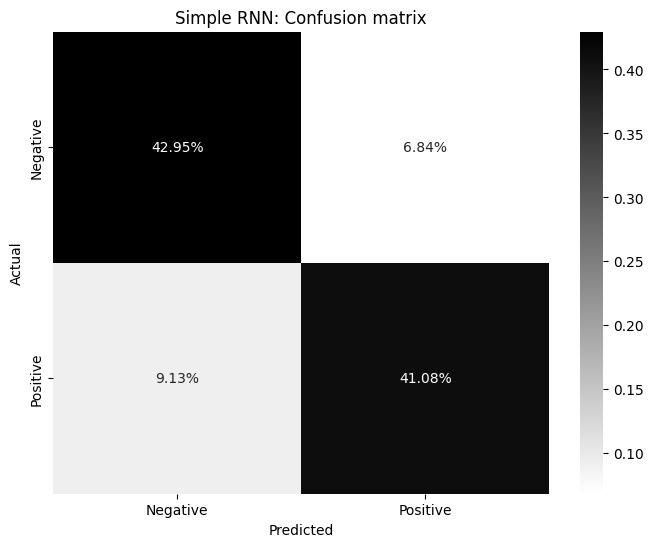

In [148]:
cm_SimpleRNN=confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_SimpleRNN/np.sum(cm_SimpleRNN), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Simple RNN: Confusion matrix')
plt.show()

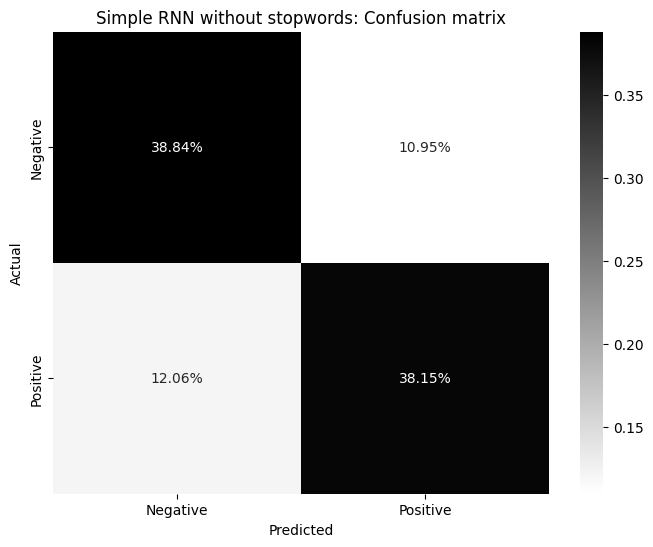

In [149]:
# Confusion matrix for Simple RNN model without stopwords
cm_SimpleRNN_ws = confusion_matrix(y_test_ws, y_pred2)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_SimpleRNN_ws/np.sum(cm_SimpleRNN_ws), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Simple RNN without stopwords: Confusion matrix')
plt.show()

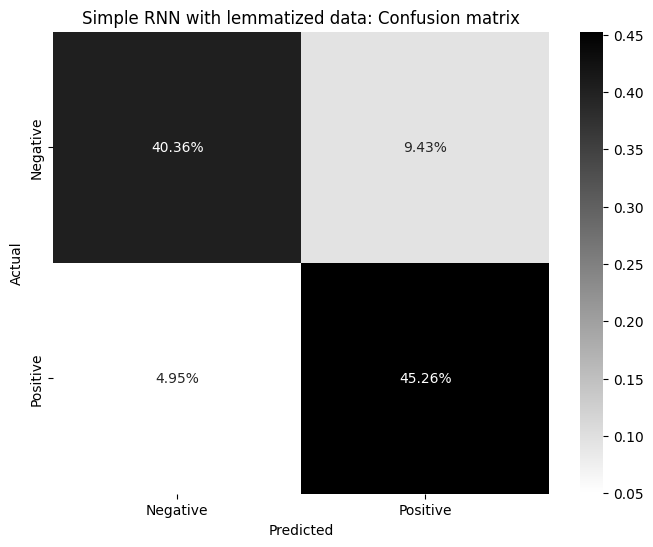

In [150]:
# Confusion matrix for Simple RNN model with lemmatized data
cm_SimpleRNN_lem = confusion_matrix(y_test_lem, y_pred3)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_SimpleRNN_lem/np.sum(cm_SimpleRNN_lem), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Simple RNN with lemmatized data: Confusion matrix')
plt.show()

### Confusion Matrices of LSTMs

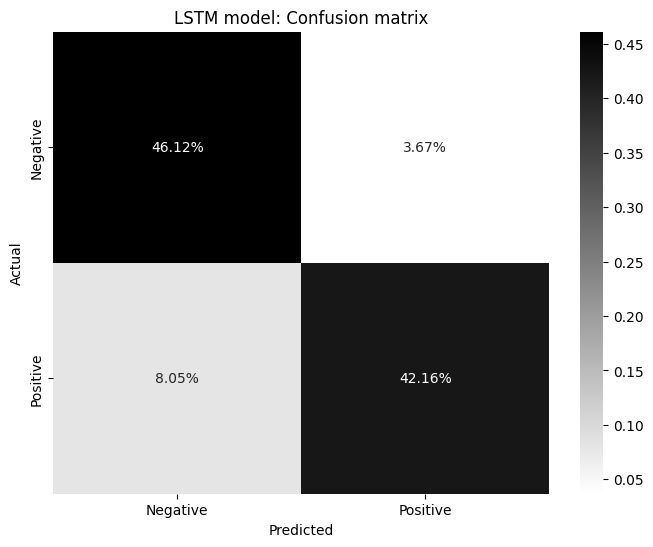

In [151]:
# Confusion matrix for LSTM model with original data
cm_LSTM = confusion_matrix(y_test, y_pred4)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_LSTM/np.sum(cm_LSTM), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM model: Confusion matrix')
plt.show()

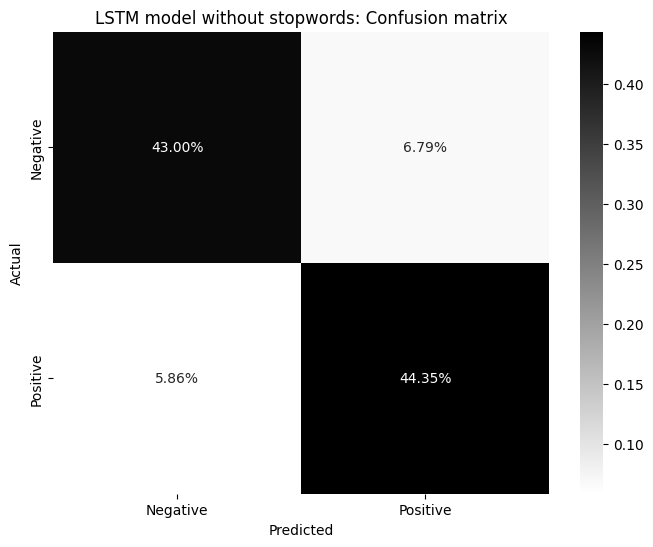

In [152]:
# Confusion matrix for LSTM model without stopwords
cm_LSTM_ws = confusion_matrix(y_test_ws, y_pred5)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_LSTM_ws/np.sum(cm_LSTM_ws), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM model without stopwords: Confusion matrix')
plt.show()

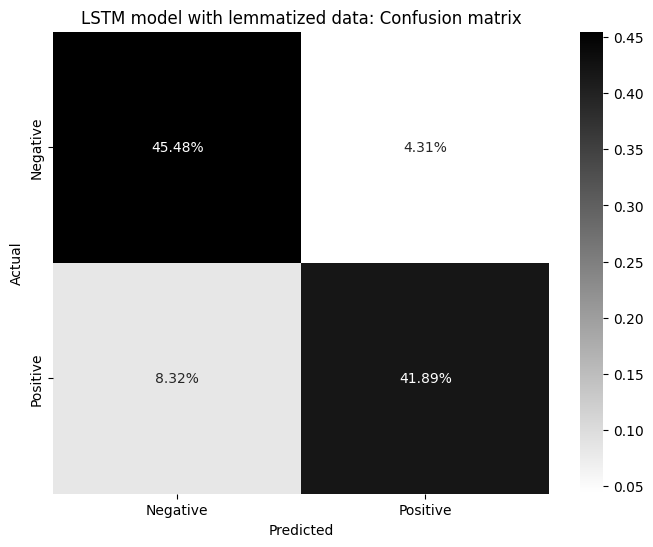

In [153]:
# Confusion matrix for LSTM model with lemmatized data
cm_LSTM_lem = confusion_matrix(y_test_lem, y_pred6)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_LSTM_lem/np.sum(cm_LSTM_lem), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM model with lemmatized data: Confusion matrix')
plt.show()

### Confusion Matrices of CNNs

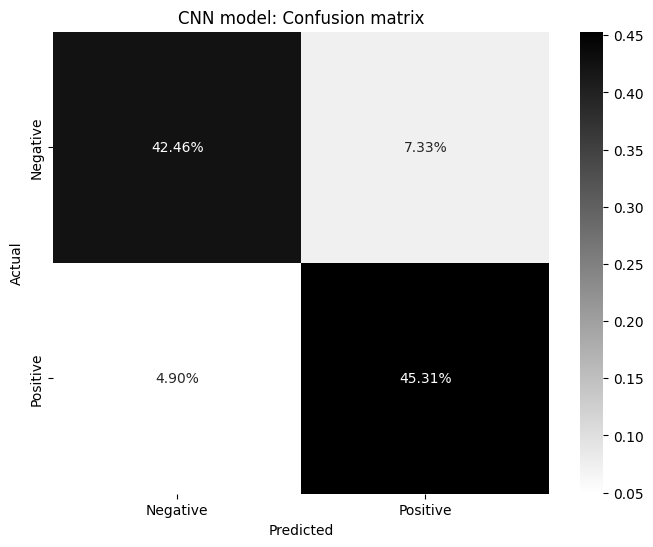

In [154]:
# Confusion matrix for CNN model with original data
cm_CNN = confusion_matrix(y_test, y_pred7)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_CNN/np.sum(cm_CNN), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN model: Confusion matrix')
plt.show()

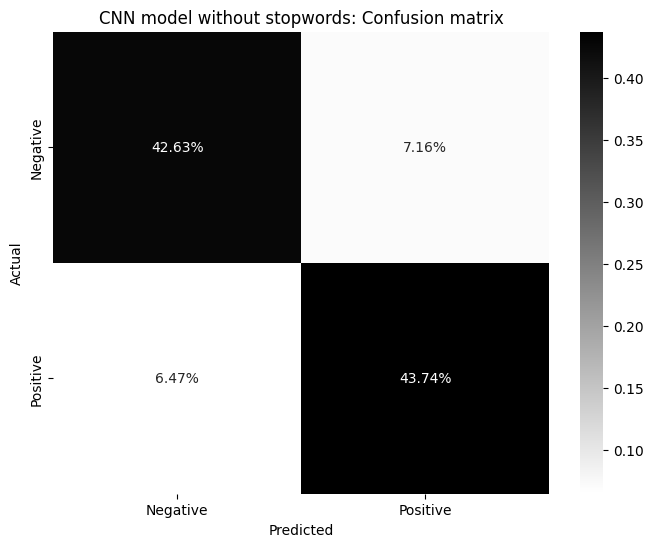

In [155]:
# Confusion matrix for CNN model without stopwords
cm_CNN_ws = confusion_matrix(y_test_ws, y_pred8)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_CNN_ws/np.sum(cm_CNN_ws), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN model without stopwords: Confusion matrix')
plt.show()

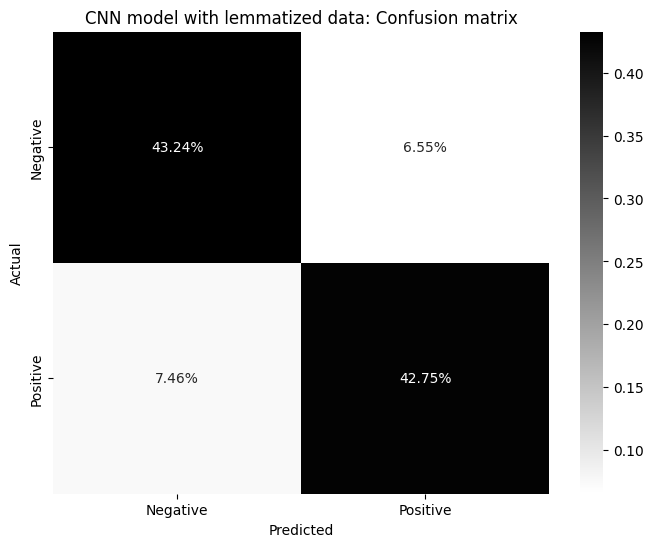

In [156]:
# Confusion matrix for CNN model with lemmatized data
cm_CNN_lem = confusion_matrix(y_test_lem, y_pred9)

plt.figure(figsize=(8,6))
# create heatmap
sns.heatmap(cm_CNN_lem/np.sum(cm_CNN_lem), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN model with lemmatized data: Confusion matrix')
plt.show()

### ROC Curves of Simple RNNs

127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step


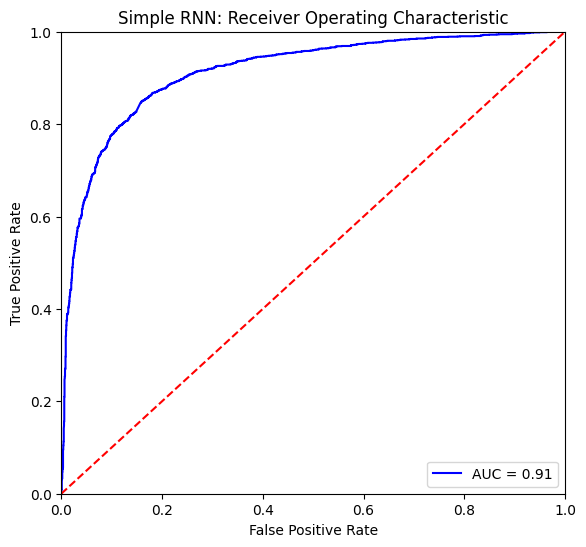

In [166]:
preds_SimpleRNN = RNN_model.predict(X_test_padded).ravel()
fpr_SimpleRNN, trp_SimpleRNN, thresholds_SimpleRNN = roc_curve(y_test, preds_SimpleRNN)
roc_auc_SimpleRNN = auc(fpr_SimpleRNN, trp_SimpleRNN)

plt.figure(figsize=(6.5,6))
plt.title('Simple RNN: Receiver Operating Characteristic')
plt.plot(fpr_SimpleRNN, trp_SimpleRNN, 'b', label = 'AUC = %0.2f' % roc_auc_SimpleRNN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


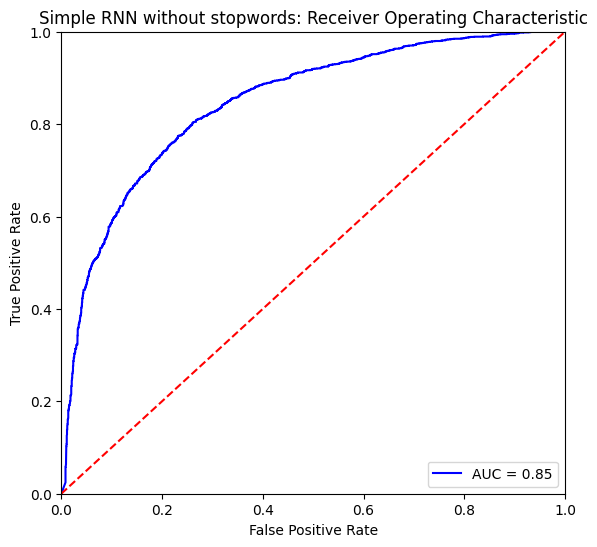

In [167]:
# ROC curve for Simple RNN model without stopwords
preds_SimpleRNN_ws = RNN_model_ws.predict(X_test_ws_padded).ravel()
fpr_SimpleRNN_ws, trp_SimpleRNN_ws, thresholds_SimpleRNN_ws = roc_curve(y_test_ws, preds_SimpleRNN_ws)
roc_auc_SimpleRNN_ws = auc(fpr_SimpleRNN_ws, trp_SimpleRNN_ws)

plt.figure(figsize=(6.5,6))
plt.title('Simple RNN without stopwords: Receiver Operating Characteristic')
plt.plot(fpr_SimpleRNN_ws, trp_SimpleRNN_ws, 'b', label = 'AUC = %0.2f' % roc_auc_SimpleRNN_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


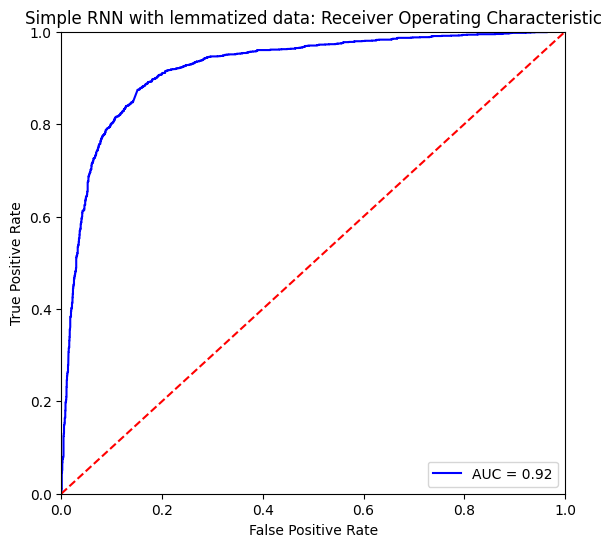

In [168]:
# ROC curve for Simple RNN model with lemmatized data
preds_SimpleRNN_lem = RNN_model_lem.predict(X_test_lem_padded).ravel()
fpr_SimpleRNN_lem, trp_SimpleRNN_lem, thresholds_SimpleRNN_lem = roc_curve(y_test_lem, preds_SimpleRNN_lem)
roc_auc_SimpleRNN_lem = auc(fpr_SimpleRNN_lem, trp_SimpleRNN_lem)

plt.figure(figsize=(6.5,6))
plt.title('Simple RNN with lemmatized data: Receiver Operating Characteristic')
plt.plot(fpr_SimpleRNN_lem, trp_SimpleRNN_lem, 'b', label = 'AUC = %0.2f' % roc_auc_SimpleRNN_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### ROC Curves of LSTMs

127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


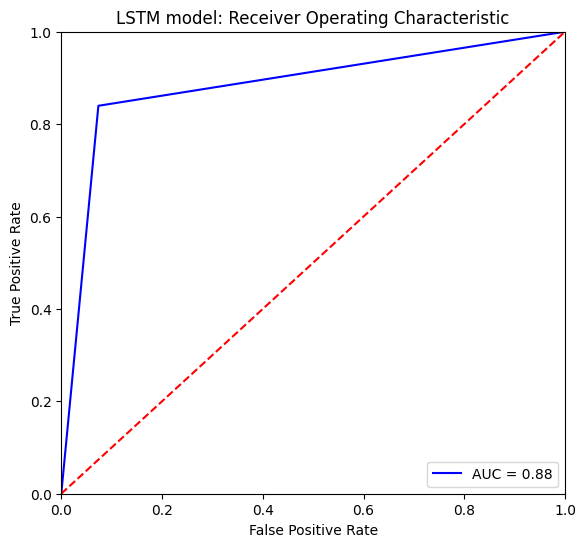

In [160]:
# ROC curve for LSTM model with original data
preds_LSTM = lstm_model.predict(X_test_padded).ravel()
fpr_LSTM, trp_LSTM, thresholds_LSTM = roc_curve(y_test, y_pred4)
roc_auc_LSTM = auc(fpr_LSTM, trp_LSTM)

plt.figure(figsize=(6.5,6))
plt.title('LSTM model: Receiver Operating Characteristic')
plt.plot(fpr_LSTM, trp_LSTM, 'b', label = 'AUC = %0.2f' % roc_auc_LSTM)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


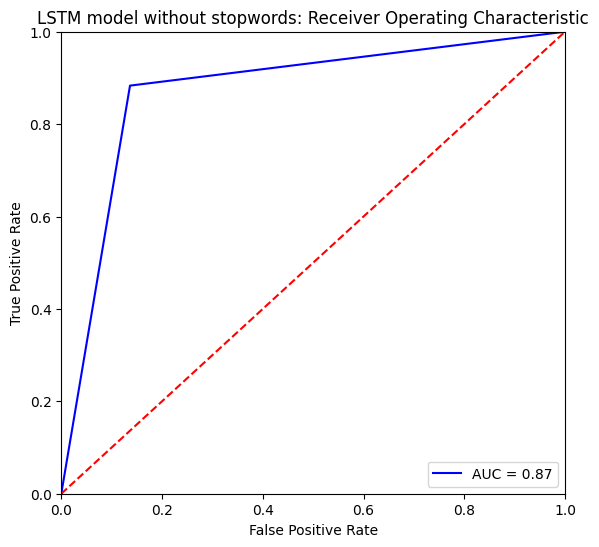

In [169]:
# ROC curve for LSTM model without stopwords
preds_LSTM_ws = lstm_model_ws.predict(X_test_ws_padded).ravel()
fpr_LSTM_ws, trp_LSTM_ws, thresholds_LSTM_ws = roc_curve(y_test_ws, y_pred5)
roc_auc_LSTM_ws = auc(fpr_LSTM_ws, trp_LSTM_ws)

plt.figure(figsize=(6.5,6))
plt.title('LSTM model without stopwords: Receiver Operating Characteristic')
plt.plot(fpr_LSTM_ws, trp_LSTM_ws, 'b', label = 'AUC = %0.2f' % roc_auc_LSTM_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


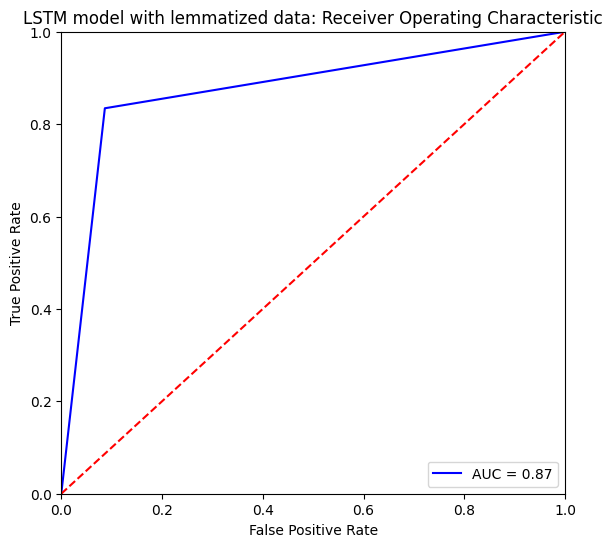

In [170]:
# ROC curve for LSTM model with lemmatized data
preds_LSTM_lem = lstm_model_lem.predict(X_test_lem_padded).ravel()
fpr_LSTM_lem, trp_LSTM_lem, thresholds_LSTM_lem = roc_curve(y_test_lem, y_pred6)
roc_auc_LSTM_lem = auc(fpr_LSTM_lem, trp_LSTM_lem)

plt.figure(figsize=(6.5,6))
plt.title('LSTM model with lemmatized data: Receiver Operating Characteristic')
plt.plot(fpr_LSTM_lem, trp_LSTM_lem, 'b', label = 'AUC = %0.2f' % roc_auc_LSTM_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### ROC Curves of CNNs

  1/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


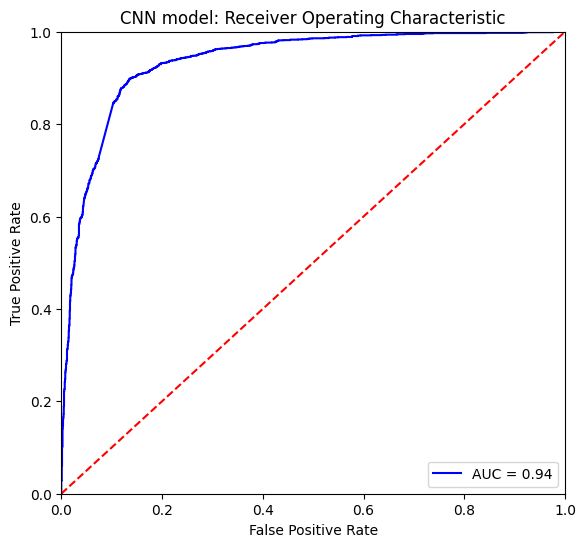

In [171]:
# ROC curve for CNN model with original data
preds_CNN = cnn_model.predict(X_test_padded).ravel()
fpr_CNN, trp_CNN, thresholds_CNN = roc_curve(y_test, preds_CNN)
roc_auc_CNN = auc(fpr_CNN, trp_CNN)

plt.figure(figsize=(6.5,6))
plt.title('CNN model: Receiver Operating Characteristic')
plt.plot(fpr_CNN, trp_CNN, 'b', label = 'AUC = %0.2f' % roc_auc_CNN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


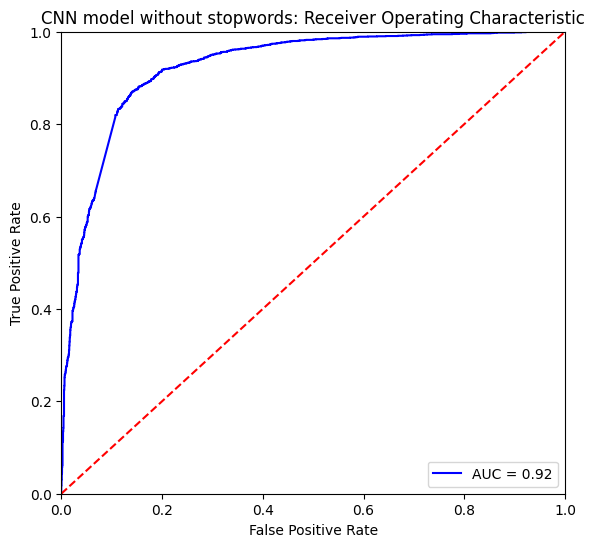

In [172]:
# ROC curve for CNN model without stopwords
preds_CNN_ws = cnn_model_ws.predict(X_test_ws_padded).ravel()
fpr_CNN_ws, trp_CNN_ws, thresholds_CNN_ws = roc_curve(y_test_ws, preds_CNN_ws)
roc_auc_CNN_ws = auc(fpr_CNN_ws, trp_CNN_ws)

plt.figure(figsize=(6.5,6))
plt.title('CNN model without stopwords: Receiver Operating Characteristic')
plt.plot(fpr_CNN_ws, trp_CNN_ws, 'b', label = 'AUC = %0.2f' % roc_auc_CNN_ws)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


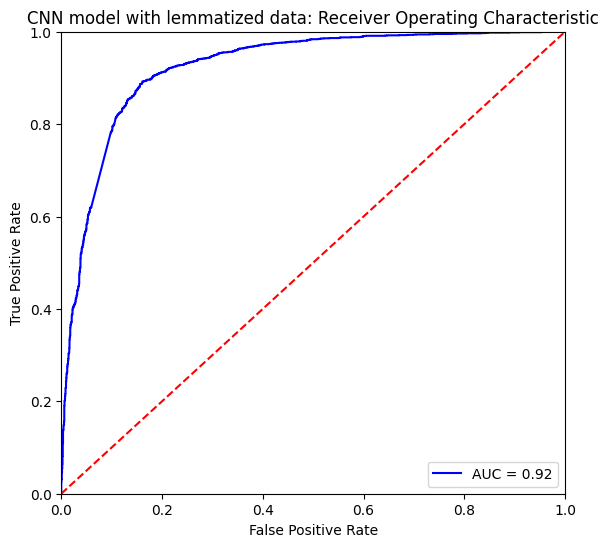

In [173]:
# ROC curve for CNN model with lemmatized data
preds_CNN_lem = cnn_model_lem.predict(X_test_lem_padded).ravel()
fpr_CNN_lem, trp_CNN_lem, thresholds_CNN_lem = roc_curve(y_test_lem, preds_CNN_lem)
roc_auc_CNN_lem = auc(fpr_CNN_lem, trp_CNN_lem)

plt.figure(figsize=(6.5,6))
plt.title('CNN model with lemmatized data: Receiver Operating Characteristic')
plt.plot(fpr_CNN_lem, trp_CNN_lem, 'b', label = 'AUC = %0.2f' % roc_auc_CNN_lem)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()